<a href="https://www.kaggle.com/code/milicaradisavljevic/mall-customer-segmentation-clustering?scriptVersionId=184557579" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


# Import the libraries

In [2]:
import pandas as pd #managing the data
import numpy as np #mathematical operations
import matplotlib.pyplot as plt #vizualization
import seaborn as sns #visualization

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings('ignore')

#Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Load the data

In [3]:
data = pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# About the data

"Mall Customer Segmentation Data" dataset from Kaggle will be used. The database was created for learning purposes. The data is not from a real example. It contains general customers informations to help us group customers and create a marketing campaign.

The dataset includes the following features:
- Customer ID: Unique ID assigned to the customer;
- Gender: Male/Female;
- Age: Age of the customer;
- Annual Income(k$): Annual Income of the customer;
- Spending Score (1-100): Score assigned by the mall based on customer behavior and spending nature;

# Objectives

The main task is to create a model that will divide customers into groups based on their characteristics. We will train several ML models(K-means and DBSCAN), and compare their results. An EDA analysis will also be performed in order to understand our data and based on which characteristics to group the data.


# Data exploration and preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


The dataset contains 200 entries and 5 columns. We have only one object dtype and no null values in the data. Since it has no impact on further analysis, we will remove the CustomerID column.


In [5]:
data=data.drop('CustomerID',axis=1)

In [6]:
#checking for duplicates 
data.duplicated().sum()

0

Excellent, no duplicates were found in the dataset.

In [7]:
data.Gender.value_counts(normalize=True)

Gender
Female    0.56
Male      0.44
Name: proportion, dtype: float64

<Axes: xlabel='Gender'>

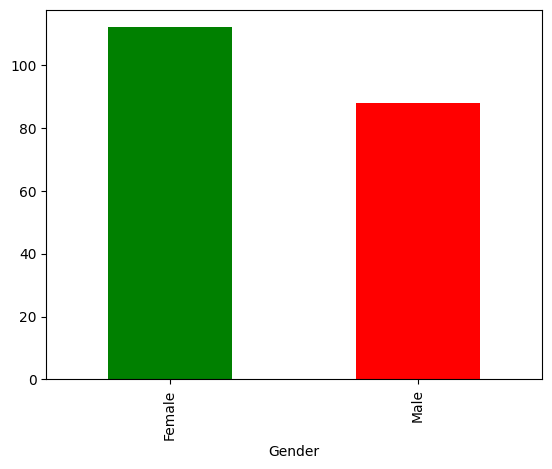

In [8]:
data.Gender.value_counts().plot.bar(color=['green', 'red'])

We notice that there are more female than male customers in the dataset. We will apply label encoding, in order to convert Male/Female into numeric values.


### Label Encoding

In [9]:
# Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Gender']


In [10]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
labeled_data = data.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
labeled_data[object_cols] = ordinal_encoder.fit_transform(data[object_cols])

# Convert NumPy array to Pandas DataFrame
labeled_data = pd.DataFrame(labeled_data)

In [11]:
labeled_data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,19,15,39
1,1.0,21,15,81
2,0.0,20,16,6
3,0.0,23,16,77
4,0.0,31,17,40


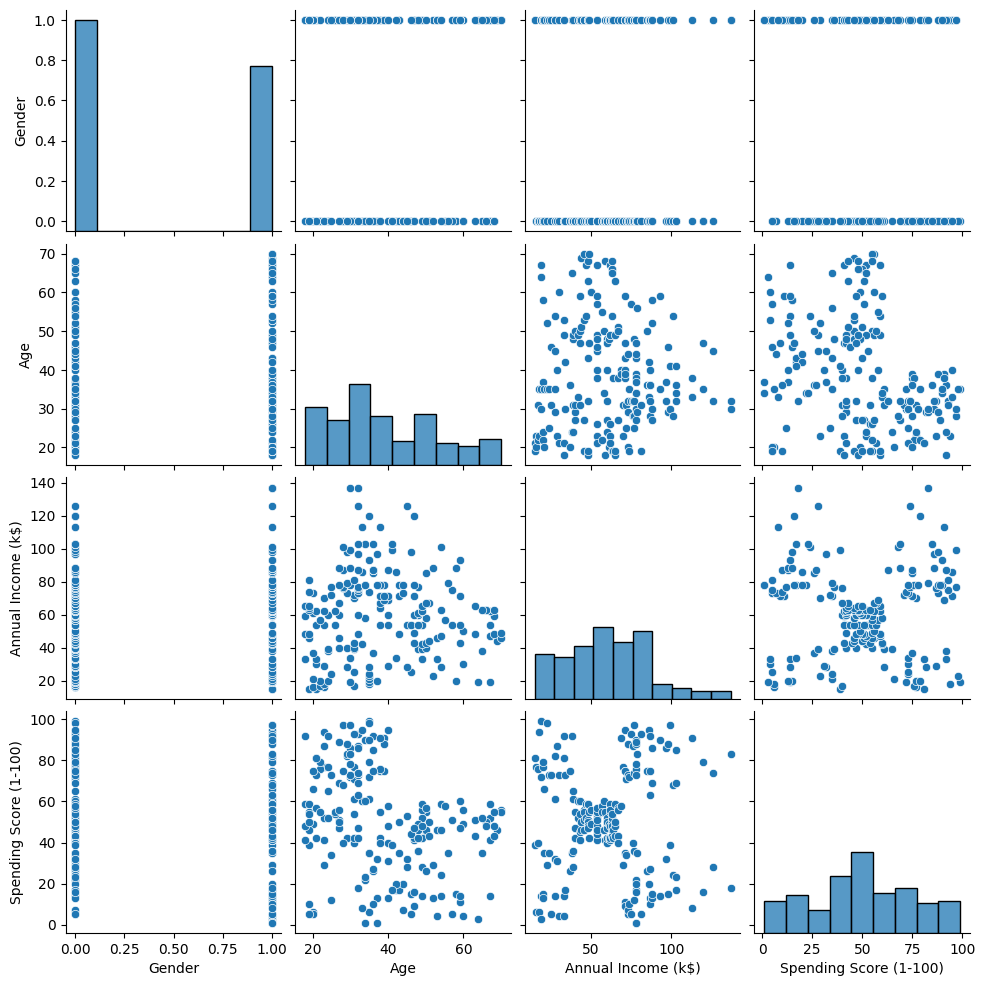

In [12]:
sns.pairplot(labeled_data)

<Axes: >

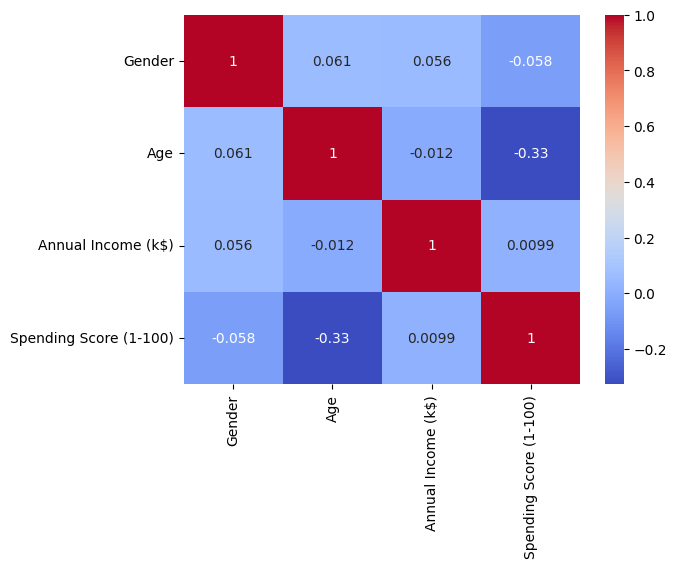

In [13]:
sns.heatmap(labeled_data.corr(),annot=True,cmap='coolwarm')

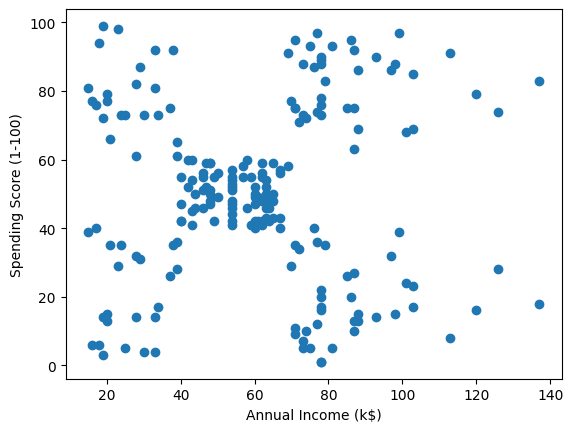

In [14]:
xlabel = 'Annual Income (k$)'
ylabel = 'Spending Score (1-100)'
X = labeled_data[[xlabel, ylabel]]
plt.scatter(X[xlabel], X[ylabel])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

Based on the "sns.pairplot(labeled_data)" diagram, we conclude that the relationship between features Annual Income and Spending Score stands out the most. Visually, we can notice that the points are already divided into 5 groups, but we will confirm this in detail with the analysis below.

# Clustering models

## K-means

K-means divides points into K clusters based on similarity. At each iteration, it assigns points to the closest cluster center, and then updates the cluster centers based on the mean of the points assigned to each cluster. This process continues until centroids converge or a maximum number of iterations is reached.

The algorithm is very sensitive to the initial placement of the centroid centers. Different centers give different results. A possible solution is the **K-means ++** algorithm.

The initialization process starts by choosing the first centroid randomly from the data points. Subsequent centroids are selected based on a probability distribution that favors points farther away from already chosen centroids. 


**StandardScaler** standardizes the features in data before applying clustering methods. This ensures that each feature contributes equally, leading to more reliable and interpretable clustering results.

In [15]:
scale = StandardScaler()
labeled_data = scale.fit_transform(X)

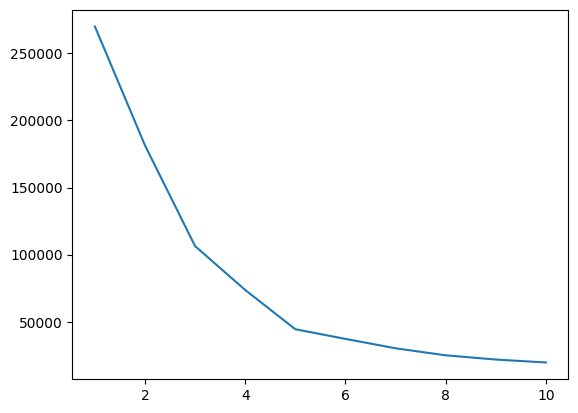

In [16]:
inertia_scores=[]

for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=42)
    kmeans.fit(X)
    inertia_scores.append(kmeans.inertia_)

plt.plot(range(1,11),inertia_scores)


The elbow method uses inertia to identify the optimal number of clusters by plotting inertia against the number of clusters and finding the point where the rate of decrease slows significantly, suggesting the appropriate cluster count.

Inertia - sum of squared distances between each data point and its assigned cluster centroid, measuring the compactness of clusters.

On the diagram, we see that the elbow is located at point 5, so we will take that value for K.

In [17]:
kmeans_model = KMeans(n_clusters= 5, init='k-means++', random_state=42)
kmeans_model.fit(X)

KMeans(n_clusters=5, random_state=42)

Cluster 0: 81 points
Cluster 1: 35 points
Cluster 2: 23 points
Cluster 3: 22 points
Cluster 4: 39 points


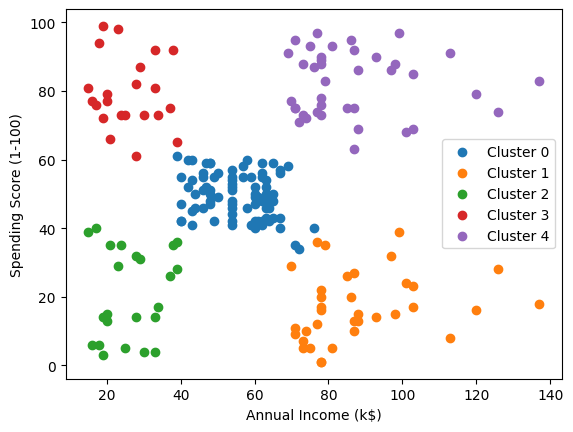

In [18]:
# Get unique cluster labels
unique_labels = np.unique(kmeans_model.labels_)

# Plotting clusters and counting points in each cluster
for label in unique_labels:
    X_ = X[kmeans_model.labels_ == label]  # Filter points for current cluster label
    plt.scatter(X_['Annual Income (k$)'], X_['Spending Score (1-100)'], label=f'Cluster {label}')
    num_points = len(X_)  # Count points in current cluster
    print(f'Cluster {label}: {num_points} points')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

- Cluster 0: 81 points (Midle Anuual Income and Midle Spending Score);
- Cluster 4: 39 points (High Annual Income and High Spening Score);
- Cluster 1: 35 points (High Annual Inome and Low Spending Score);
- Cluster 2: 23 points (Low Annual Income and Low Spending Score);
- Cluster 3: 22 points (Low Annual Income and High Spending Score).

## DBSCAN

DBSCAN groups points based on density. Works by identifying dense regions in the data and forming clusters based on these regions. It is very effective in identifying clusters of different shapes and sizes, resistant to outliers, but it is sensitive to the choice of parameters.

Parameters:
- **eps** (epsilon) - max distance between two points to be considered as the same neighborhood;
- **min_samples** - min number of neighbors a point need to be a core point.

If a point has at least the minimum number of neighbors (min_samples) within the radius eps, it is considered a core point and is included in a cluster. Points that are directly or indirectly reachable from this core point also become part of the *cluster*. 

If a point does not have the required number of neighbors within the eps radius and cannot be reached by other core points, it is classified as *noise*.
 

In [19]:
# Define parameter grid
param_grid = {
    'eps': np.arange(1, 15, 5),
    'min_samples': np.arange(3, 10, 1)
}

# Initialize best parameters
params = None

# Perform grid search
for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X)
    
# Print best parameters and best score
print("Best parameters:", params)

Best parameters: {'eps': 11, 'min_samples': 9}


In [20]:
db_model = DBSCAN(eps=11, min_samples=9)
db_model.fit(X)

DBSCAN(eps=11, min_samples=9)

Cluster -1: 31 points
Cluster 0: 14 points
Cluster 1: 9 points
Cluster 2: 93 points
Cluster 3: 30 points
Cluster 4: 23 points


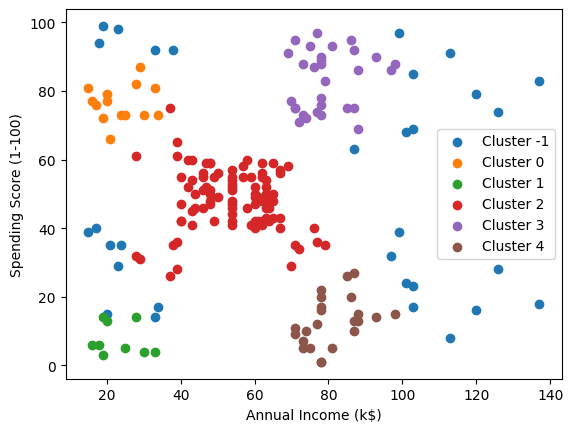

In [21]:
# Get unique cluster labels
db_unique_labels = np.unique(db_model.labels_)

# Plotting clusters and counting points in each cluster
for label in db_unique_labels:
    X_ = X[db_model.labels_ == label]  # Filter points for current cluster label
    plt.scatter(X_['Annual Income (k$)'], X_['Spending Score (1-100)'], label=f'Cluster {label}')
    num_points = len(X_)  # Count points in current cluster
    print(f'Cluster {label}: {num_points} points')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

DBSCAN found 5 clusters and 31 points of noise. From the diagram, we can see that he did not group the data well.


# Key Findings

2 models, K-means and DBSCAN, were trained and based on the obtained results, K-means is proposed as the final model. With the k-means model, we see a clear clustering of customers, unlike DBSCAN.

5 customer groups were clearly distinguished:

- Low Annual Income and Low Spending Score;
- Low Annual Income and High Spending Score;
- Midle Anuual Income and Midle Spending Score;
- High Annual Inome and Low Spending Score;
- High Annual Income and High Spening Score;

#  Suggestions for Next Steps

- Additional Data: Consider incorporating additional demographic or behavioral data to enrich customer segmentation;
- Alternative Models: Exploring Means Shift, GMM or other methods can potentially improve performances;
- Feature Engineering: Investigating additional features or transformations could provide better model accuracy.